Источник данных - сводная таблица по транзакциям онлайн-ретейлера из Великобритании
Ссылка на источник - https://www.kaggle.com/carrie1/ecommerce-data

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 14,9

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Импортируем данные. Избавимся от наименований конкретных товаров, выбросим отрицательные значения там, где их не должно быть, сгруппируем по чекам и посчитаем, сколько денег потрачено суммарно по каждому чеку, добавим в соответствующий столбец. Приведем дату к типу datetime

In [16]:
dataset = pd.read_csv('data.csv',  encoding='unicode-escape')
dataset = dataset[['InvoiceNo', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'Country']]

filter_neg = dataset[dataset['Quantity'] <= 0].index
dataset.drop(filter_neg, inplace = True)
filter_neg = dataset[dataset['UnitPrice'] <= 0].index
dataset.drop(filter_neg, inplace = True)

dataset['TotAmount'] = dataset ['UnitPrice'] * dataset['Quantity']

group_rules = {'TotAmount' : 'sum', 'Country' : 'first', 'Quantity' : 'sum', 'InvoiceDate' : 'first'}
dataset = dataset.groupby('InvoiceNo').agg(group_rules)
dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])
dataset

,TotAmount,Country,Quantity,InvoiceDate
InvoiceNo,,,,
536365,139.12,United Kingdom,40,2010-12-01 08:26:00
536366,22.20,United Kingdom,12,2010-12-01 08:28:00
536367,278.73,United Kingdom,83,2010-12-01 08:34:00
536368,70.05,United Kingdom,15,2010-12-01 08:34:00
536369,17.85,United Kingdom,3,2010-12-01 08:35:00
...,...,...,...,...
581584,140.64,United Kingdom,120,2011-12-09 12:25:00
581585,329.05,United Kingdom,278,2011-12-09 12:31:00
581586,339.20,United Kingdom,66,2011-12-09 12:49:00


Посмотрим, есть ли в наших данных выбросы, и много ли их в целом. Для этого построим точечную диаграмму из всех покупок - потраченных денег и стран, из которых были оформлены заказы

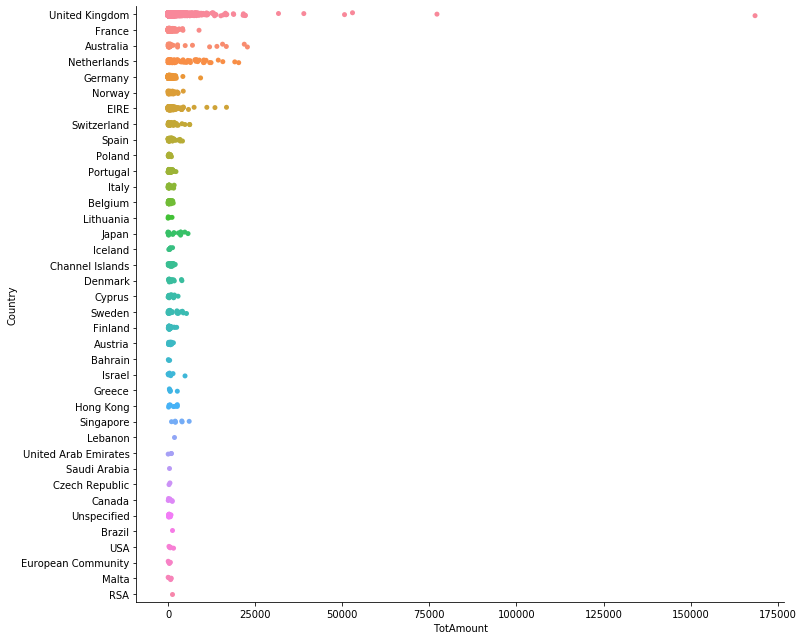

In [18]:
sns_plot = sns.catplot(x='TotAmount', y = 'Country', data = dataset, height = 9, aspect = 1.25)
sns_plot

Как мы видим, выбросы присутствуют, но их не слишком много. Вычислим 97-ю процентиль и уберем из нашего массива данных все выбросы, которые превышают этот показатель

In [19]:
dataset.quantile(q = 0.97)

TotAmount    2232.2944
Quantity     1121.2300
Name: 0.97, dtype: float64

In [20]:
dataset = dataset[dataset['TotAmount'] <= 2232]

Сгруппируем массив по странам и посмотрим, какие страны в среднем тратят больше всего денег. 

In [21]:
mean_total = dataset.groupby('Country').agg({'TotAmount' : 'mean'})
mean_total = mean_total.sort_values('TotAmount')

<BarContainer object of 38 artists>

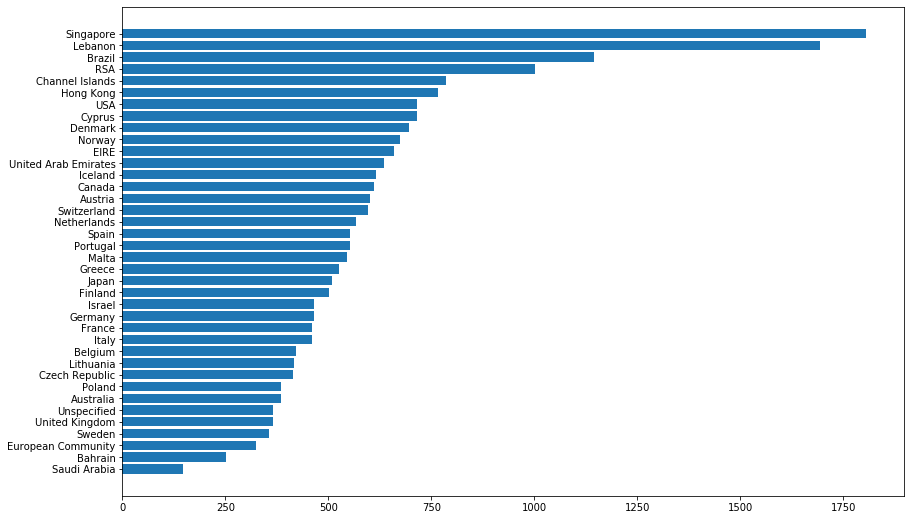

In [22]:
plt.barh(mean_total.index, mean_total['TotAmount'])

Как мы видим, Европейские страны находятся внизу таблицы. Скорее всего это, это связано с тем, что стоимость доставки в Европу довольно невелика, поэтому можно позволить себе покупать малыми партиями. А вот при заказе на другие континеты лучше сгруппировать покупки

Далее посмотрим на распределение "среднего чека" в целом у данного ретейлера, построим гистограмму распределения средних затрат по чекам.

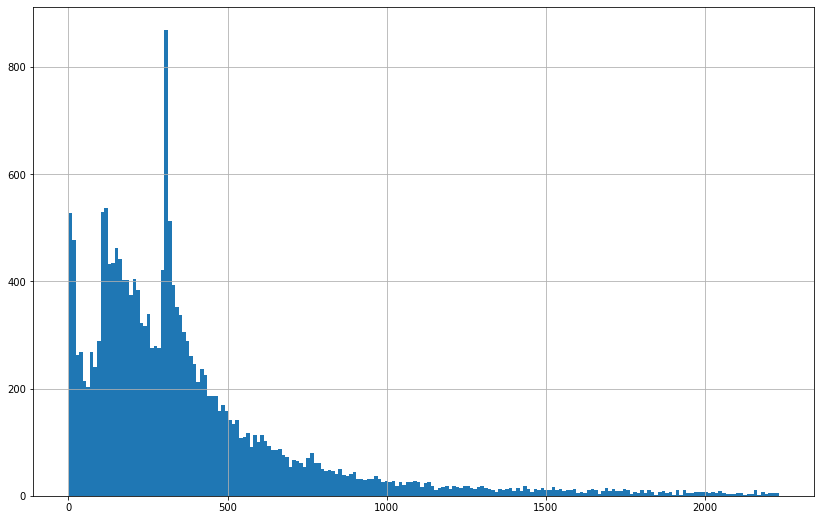

In [23]:
dataset.TotAmount.hist(bins =200)

В основном все покупки укладываются до 500 фунтов, при этом есть явный пик в районе 300-400 фунтов. Это может быть связано с тем, что, например, самые популярные товары в этом магазине находятся именно в этом диапазоне. Также это может быть связано с тем, что в этом диапазоне доставка наиболее выгодна.

Далее сгруппируем массив данных по месяцам и посмотрим, как меняется объем продаж в течение года:

In [24]:
dataset_months = dataset.groupby(pd.Grouper(key = 'InvoiceDate', freq = 'M')).agg({'TotAmount' : 'mean'})

(250, 475)

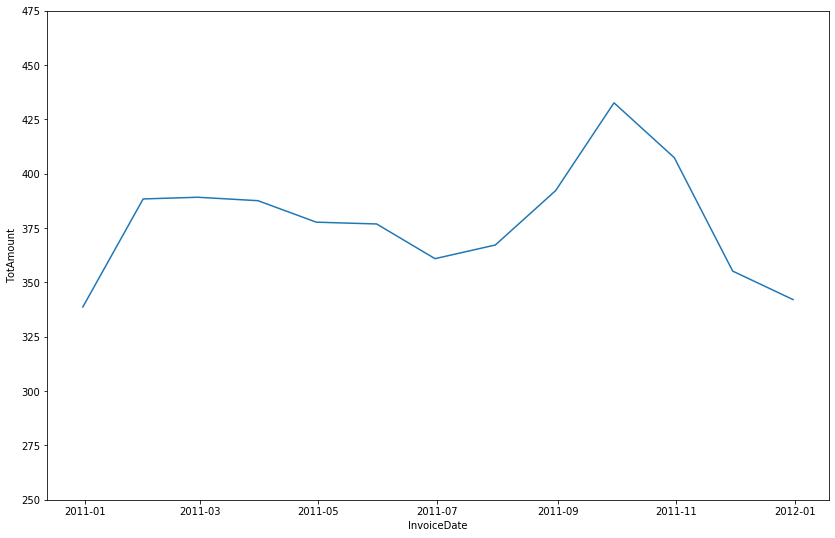

In [25]:
sns.lineplot(x = dataset_months.index , y = 'TotAmount', data = dataset_months)
plt.ylim(250, 475)


Можно наблюдать, что в начале и конце года есть явные проседания, при этом явный пик - в октябре - ноябре. Скорее всего это связано с тем, что многие люди покупают подарки к новогодним праздникам заранее, особенно в период распродаж (Черная пятница, и т.п.)

Далее попробуем посмотреть, из каких стран в основном заказывают в этом магазине:

In [26]:
top_money_spent = dataset.groupby('Country').agg({'TotAmount' : 'sum'})
top_money_spent = top_money_spent.sort_values('TotAmount', ascending = False).head(10)

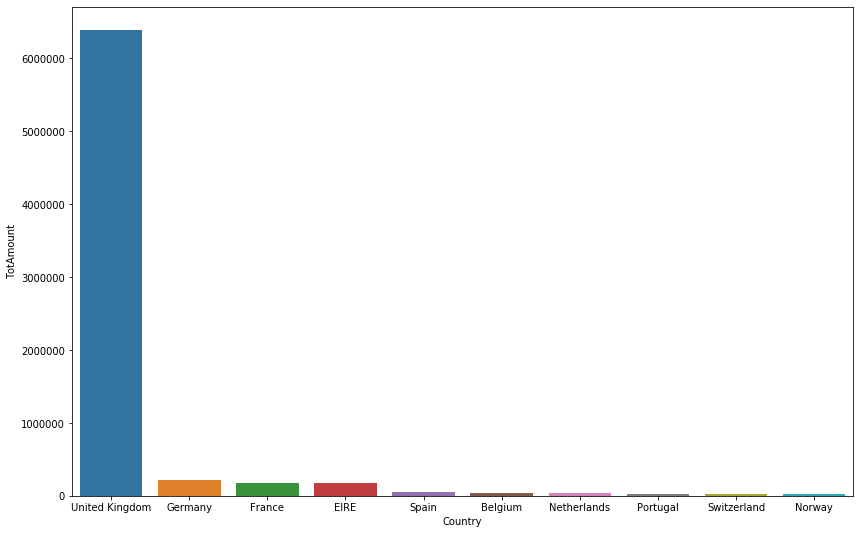

In [27]:
sns.barplot(x = top_money_spent.index, y = 'TotAmount', data = top_money_spent)

Результат вполне ожидаем. Подавляющее большинство денег потрачено в этом магазине покупателями из Соединенного королевства.